In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from typing import Tuple, List, Type, Dict, Any

In [4]:
from hidden_functions import *

In [5]:
model = Perceptron(hidden_layer_features=[512, 256, 128, 32], activation=torch.nn.GELU, num_classes=10)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): GELU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): GELU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): GELU()
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): GELU()
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)
Total number of trainable parameters 570602


In [6]:
model = model.cuda()

In [7]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(.5, 1.0), ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [8]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

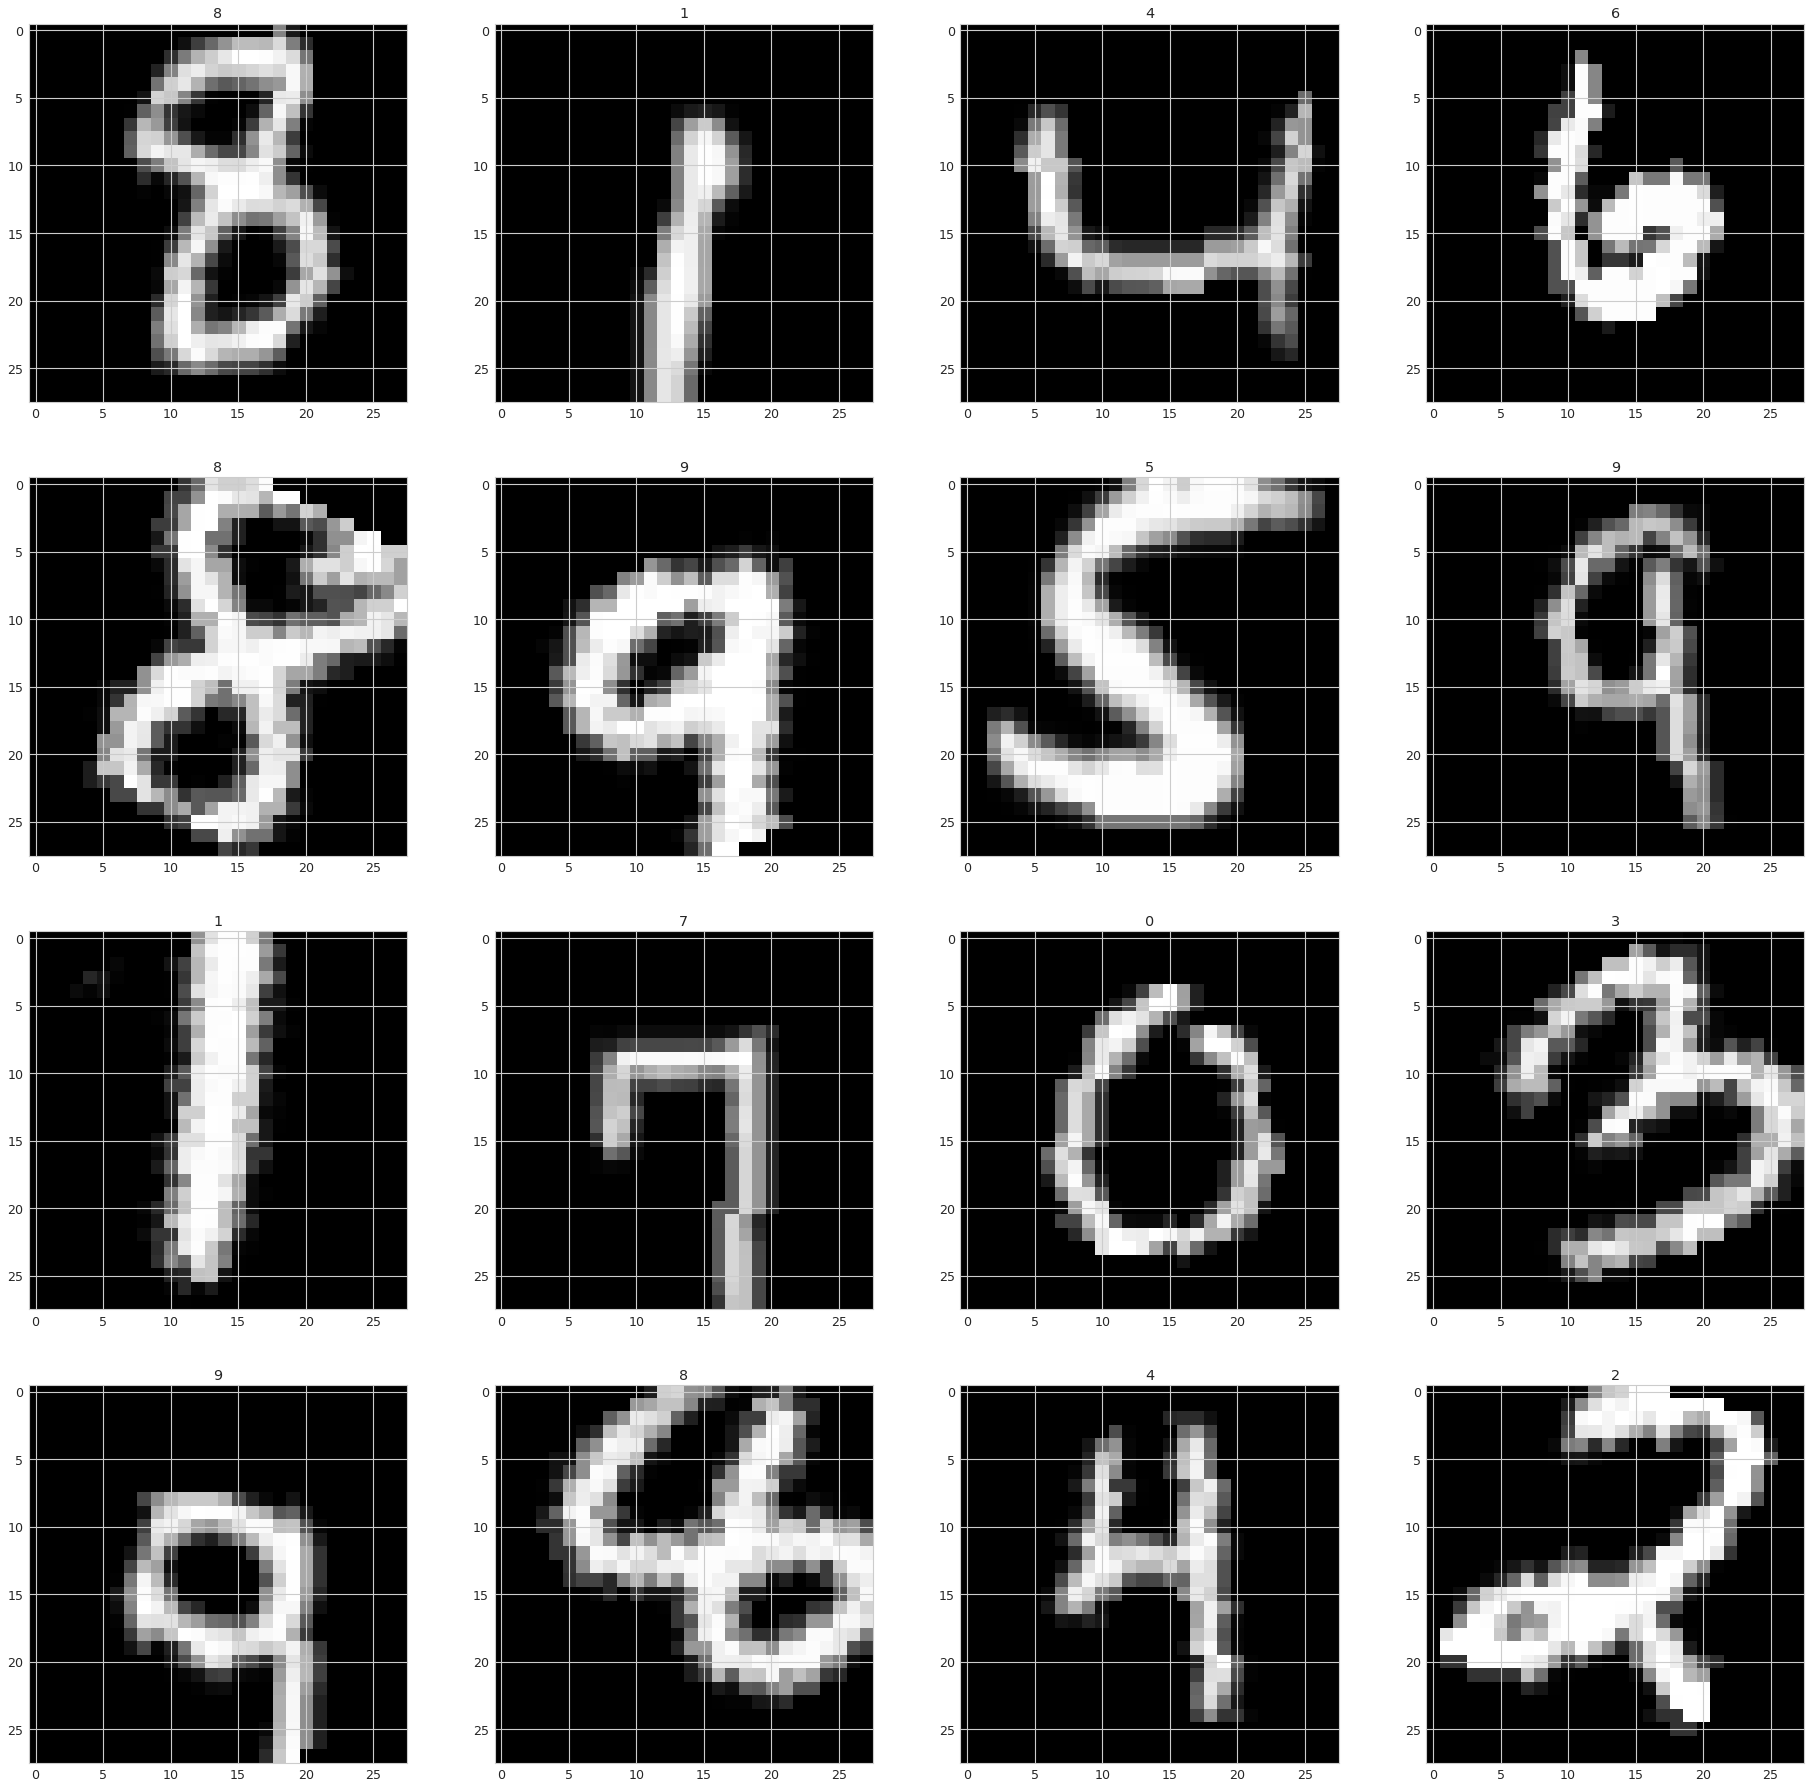

In [9]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*4+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(np.squeeze(sample.cpu().numpy().transpose(1, 2, 0)), cmap='gray')
        ax.set_title(label)

In [10]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 10):
    
    #region TENSORBOARD tutorial
    tb_writer = SummaryWriter(log_dir='./logs/run003/')
    #endregion ##############################
    
    #region borrowed from HW03
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    loss_history = []
    #endregion borrowed from HW03
    
    for epoch in range(max_epochs):
        #region borrowed from HW03
        print(f'Epoch {epoch}')
        train_epoch_loss_history = train_single_epoch(model, optimizer, loss_function, train_loader, tb_writer, epoch)
        loss_history = loss_history+train_epoch_loss_history
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        #endregion ##############################
        
        #region TENSORBOARD tutorial
        tb_writer.add_scalar('train_loss', np.sum(train_epoch_loss_history)/len(train_loader.dataset), global_step=epoch)
        tb_writer.add_scalar('val_loss', val_metrics['loss'], global_step=epoch)
        tb_writer.add_scalar('val_accuracy', val_metrics['accuracy'], global_step=epoch)
        #endregion ##############################
        
        #region borrowed from HW03
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return
        #endregion ##############################

In [11]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.0001,
            max_epochs=100)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 0


  0%|          | 4/938 [00:00<00:27, 34.25it/s]

Validation metrics: 
{'loss': 0.0055126033782958985, 'accuracy': 0.9074}
Best model yet, saving
Epoch 1


  0%|          | 4/938 [00:00<00:27, 34.07it/s]

Validation metrics: 
{'loss': 0.003743372344970703, 'accuracy': 0.9305}
Best model yet, saving
Epoch 2


  0%|          | 4/938 [00:00<00:25, 35.99it/s]

Validation metrics: 
{'loss': 0.0028275304794311523, 'accuracy': 0.9488}
Best model yet, saving
Epoch 3


  0%|          | 4/938 [00:00<00:26, 35.17it/s]

Validation metrics: 
{'loss': 0.002321161460876465, 'accuracy': 0.9568}
Best model yet, saving
Epoch 4


  0%|          | 4/938 [00:00<00:27, 34.08it/s]

Validation metrics: 
{'loss': 0.0022556936264038086, 'accuracy': 0.9567}
Best model yet, saving
Epoch 5


  0%|          | 4/938 [00:00<00:26, 34.69it/s]

Validation metrics: 
{'loss': 0.0018675207138061523, 'accuracy': 0.9634}
Best model yet, saving
Epoch 6


  0%|          | 4/938 [00:00<00:26, 35.01it/s]

Validation metrics: 
{'loss': 0.0016213983535766602, 'accuracy': 0.9708}
Best model yet, saving
Epoch 7


  0%|          | 4/938 [00:00<00:26, 34.76it/s]

Validation metrics: 
{'loss': 0.0014565519332885742, 'accuracy': 0.9711}
Best model yet, saving
Epoch 8


  0%|          | 4/938 [00:00<00:27, 34.17it/s]

Validation metrics: 
{'loss': 0.0016453037261962892, 'accuracy': 0.9678}
Epoch 9


  0%|          | 4/938 [00:00<00:27, 34.26it/s]

Validation metrics: 
{'loss': 0.0015002084732055664, 'accuracy': 0.9715}
Epoch 10


  0%|          | 4/938 [00:00<00:27, 34.42it/s]

Validation metrics: 
{'loss': 0.0012859746932983398, 'accuracy': 0.9744}
Best model yet, saving
Epoch 11


  0%|          | 4/938 [00:00<00:26, 34.85it/s]

Validation metrics: 
{'loss': 0.0012880466461181641, 'accuracy': 0.9747}
Epoch 12


  0%|          | 4/938 [00:00<00:26, 34.76it/s]

Validation metrics: 
{'loss': 0.0011839658737182617, 'accuracy': 0.9751}
Best model yet, saving
Epoch 13


  0%|          | 4/938 [00:00<00:26, 34.83it/s]

Validation metrics: 
{'loss': 0.0011725486755371094, 'accuracy': 0.976}
Best model yet, saving
Epoch 14


  0%|          | 4/938 [00:00<00:26, 35.15it/s]

Validation metrics: 
{'loss': 0.0010568509101867676, 'accuracy': 0.9786}
Best model yet, saving
Epoch 15


  0%|          | 4/938 [00:00<00:26, 35.31it/s]

Validation metrics: 
{'loss': 0.0010460060119628907, 'accuracy': 0.9782}
Best model yet, saving
Epoch 16


  0%|          | 4/938 [00:00<00:27, 34.38it/s]

Validation metrics: 
{'loss': 0.0010155677795410157, 'accuracy': 0.9798}
Best model yet, saving
Epoch 17


  0%|          | 4/938 [00:00<00:26, 35.60it/s]

Validation metrics: 
{'loss': 0.0010543519973754882, 'accuracy': 0.9788}
Epoch 18


  0%|          | 4/938 [00:00<00:26, 34.63it/s]

Validation metrics: 
{'loss': 0.0011714042663574218, 'accuracy': 0.9777}
Epoch 19


  0%|          | 4/938 [00:00<00:27, 34.57it/s]

Validation metrics: 
{'loss': 0.0009242976188659668, 'accuracy': 0.9817}
Best model yet, saving
Epoch 20


  0%|          | 4/938 [00:00<00:27, 34.46it/s]

Validation metrics: 
{'loss': 0.0010384491920471192, 'accuracy': 0.9788}
Epoch 21


  0%|          | 4/938 [00:00<00:26, 34.65it/s]

Validation metrics: 
{'loss': 0.0010083426475524903, 'accuracy': 0.9786}
Epoch 22


  0%|          | 4/938 [00:00<00:29, 31.43it/s]

Validation metrics: 
{'loss': 0.0009297988891601562, 'accuracy': 0.9801}
Epoch 23


  0%|          | 4/938 [00:00<00:26, 35.51it/s]

Validation metrics: 
{'loss': 0.0008447683334350586, 'accuracy': 0.9834}
Best model yet, saving
Epoch 24


  0%|          | 4/938 [00:00<00:27, 34.30it/s]

Validation metrics: 
{'loss': 0.000934527587890625, 'accuracy': 0.9811}
Epoch 25


  0%|          | 4/938 [00:00<00:26, 35.11it/s]

Validation metrics: 
{'loss': 0.0009048478126525879, 'accuracy': 0.9817}
Epoch 26


  0%|          | 4/938 [00:00<00:26, 35.63it/s]

Validation metrics: 
{'loss': 0.0008425228118896485, 'accuracy': 0.9832}
Best model yet, saving
Epoch 27


  0%|          | 4/938 [00:00<00:26, 35.25it/s]

Validation metrics: 
{'loss': 0.000825289249420166, 'accuracy': 0.9841}
Best model yet, saving
Epoch 28


  0%|          | 4/938 [00:00<00:27, 34.03it/s]

Validation metrics: 
{'loss': 0.0007914248466491699, 'accuracy': 0.9839}
Best model yet, saving
Epoch 29


  0%|          | 4/938 [00:00<00:27, 34.36it/s]

Validation metrics: 
{'loss': 0.0008084783554077148, 'accuracy': 0.9819}
Epoch 30


  0%|          | 4/938 [00:00<00:26, 35.35it/s]

Validation metrics: 
{'loss': 0.0007866760730743408, 'accuracy': 0.9837}
Best model yet, saving
Epoch 31


  0%|          | 4/938 [00:00<00:26, 34.72it/s]

Validation metrics: 
{'loss': 0.0008019037246704101, 'accuracy': 0.9834}
Epoch 32


  0%|          | 3/938 [00:00<00:35, 26.13it/s]

Validation metrics: 
{'loss': 0.0008194140434265137, 'accuracy': 0.9829}
Epoch 33


  0%|          | 4/938 [00:00<00:28, 33.24it/s]

Validation metrics: 
{'loss': 0.0007895929336547852, 'accuracy': 0.9831}
Epoch 34


  0%|          | 4/938 [00:00<00:26, 35.27it/s]

Validation metrics: 
{'loss': 0.0008252805709838868, 'accuracy': 0.9825}
Epoch 35


  0%|          | 4/938 [00:00<00:27, 34.14it/s]

Validation metrics: 
{'loss': 0.0008054195404052734, 'accuracy': 0.9825}
Epoch 36


  0%|          | 4/938 [00:00<00:27, 34.45it/s]

Validation metrics: 
{'loss': 0.0007600658893585205, 'accuracy': 0.9845}
Best model yet, saving
Epoch 37


  0%|          | 4/938 [00:00<00:27, 34.51it/s]

Validation metrics: 
{'loss': 0.0007459189414978027, 'accuracy': 0.9843}
Best model yet, saving
Epoch 38


  0%|          | 4/938 [00:00<00:26, 34.72it/s]

Validation metrics: 
{'loss': 0.0007609988212585449, 'accuracy': 0.9841}
Epoch 39


  0%|          | 4/938 [00:00<00:27, 34.27it/s]

Validation metrics: 
{'loss': 0.000772909688949585, 'accuracy': 0.9836}
Epoch 40


  0%|          | 4/938 [00:00<00:27, 34.53it/s]

Validation metrics: 
{'loss': 0.0007624713897705078, 'accuracy': 0.9842}
Epoch 41


  0%|          | 4/938 [00:00<00:26, 35.10it/s]

Validation metrics: 
{'loss': 0.0006819634437561035, 'accuracy': 0.986}
Best model yet, saving
Epoch 42


  0%|          | 4/938 [00:00<00:26, 35.37it/s]

Validation metrics: 
{'loss': 0.0006990938663482666, 'accuracy': 0.9854}
Epoch 43


  0%|          | 4/938 [00:00<00:26, 35.49it/s]

Validation metrics: 
{'loss': 0.0006398324489593506, 'accuracy': 0.9865}
Best model yet, saving
Epoch 44


  0%|          | 4/938 [00:00<00:27, 34.35it/s]

Validation metrics: 
{'loss': 0.0006381711483001708, 'accuracy': 0.9872}
Best model yet, saving
Epoch 45


  0%|          | 4/938 [00:00<00:26, 35.24it/s]

Validation metrics: 
{'loss': 0.0006816646099090576, 'accuracy': 0.986}
Epoch 46


  0%|          | 4/938 [00:00<00:26, 34.85it/s]

Validation metrics: 
{'loss': 0.0006503485202789306, 'accuracy': 0.9861}
Epoch 47


  0%|          | 4/938 [00:00<00:26, 34.84it/s]

Validation metrics: 
{'loss': 0.0006231919288635254, 'accuracy': 0.9867}
Best model yet, saving
Epoch 48


  0%|          | 4/938 [00:00<00:26, 35.45it/s]

Validation metrics: 
{'loss': 0.0006388150691986084, 'accuracy': 0.9864}
Epoch 49


  0%|          | 4/938 [00:00<00:26, 34.95it/s]

Validation metrics: 
{'loss': 0.0006594624042510986, 'accuracy': 0.9855}
Epoch 50


  0%|          | 4/938 [00:00<00:27, 34.51it/s]

Validation metrics: 
{'loss': 0.0006923481941223144, 'accuracy': 0.9851}
Epoch 51


  0%|          | 4/938 [00:00<00:26, 34.79it/s]

Validation metrics: 
{'loss': 0.0007211337089538574, 'accuracy': 0.9845}
Epoch 52


  0%|          | 4/938 [00:00<00:26, 35.34it/s]

Validation metrics: 
{'loss': 0.000677944278717041, 'accuracy': 0.9851}
Epoch 53


  0%|          | 4/938 [00:00<00:26, 35.28it/s]

Validation metrics: 
{'loss': 0.0007013957023620605, 'accuracy': 0.9857}
Epoch 54


  0%|          | 4/938 [00:00<00:28, 32.29it/s]

Validation metrics: 
{'loss': 0.0006573990821838379, 'accuracy': 0.9865}
Epoch 55


  0%|          | 4/938 [00:00<00:26, 34.83it/s]

Validation metrics: 
{'loss': 0.0005689761638641357, 'accuracy': 0.9882}
Best model yet, saving
Epoch 56


  0%|          | 4/938 [00:00<00:27, 34.33it/s]

Validation metrics: 
{'loss': 0.0007001563549041748, 'accuracy': 0.9845}
Epoch 57


  0%|          | 4/938 [00:00<00:26, 35.46it/s]

Validation metrics: 
{'loss': 0.0006782784461975098, 'accuracy': 0.9856}
Epoch 58


  0%|          | 4/938 [00:00<00:26, 35.16it/s]

Validation metrics: 
{'loss': 0.0006961129665374756, 'accuracy': 0.9852}
Epoch 59


  0%|          | 4/938 [00:00<00:27, 34.28it/s]

Validation metrics: 
{'loss': 0.0007405837535858154, 'accuracy': 0.9845}
Epoch 60


  0%|          | 4/938 [00:00<00:26, 35.35it/s]

Validation metrics: 
{'loss': 0.0006050204753875732, 'accuracy': 0.9868}
Epoch 61


  0%|          | 4/938 [00:00<00:26, 34.92it/s]

Validation metrics: 
{'loss': 0.0006562373161315918, 'accuracy': 0.9857}
Epoch 62


  0%|          | 4/938 [00:00<00:26, 35.18it/s]

Validation metrics: 
{'loss': 0.0007321619987487793, 'accuracy': 0.9857}
Epoch 63


  0%|          | 4/938 [00:00<00:26, 35.62it/s]

Validation metrics: 
{'loss': 0.0006038978099822998, 'accuracy': 0.9872}
Epoch 64


  0%|          | 4/938 [00:00<00:26, 35.80it/s]

Validation metrics: 
{'loss': 0.0005745505809783936, 'accuracy': 0.9874}
Epoch 65


  0%|          | 3/938 [00:00<00:32, 28.62it/s]

Validation metrics: 
{'loss': 0.000610606575012207, 'accuracy': 0.9881}
Epoch 66


100%|██████████| 157/157 [00:02<00:00, 63.16it/s]

Validation metrics: 
{'loss': 0.0006239396095275879, 'accuracy': 0.9866}
Early stopping triggered
